# 1. Импорт модулей и библиотек 

In [254]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchmetrics import F1Score, ROC
from torchvision.datasets import CIFAR100
import pytorch_lightning as pl

import numpy as np
import random
import matplotlib.pyplot as plt

# 2. Обеспечение воспроизводимости

In [255]:
pl.seed_everything(42) # P.S. Спасибо за подсказку!

Seed set to 42


42

In [256]:
from torchvision import transforms

class CIFAR100_DataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "./data", batch_size: int = 64, num_workers: int = 2):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
            transforms.Resize((12, 12)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def prepare_data(self):
        datasets.CIFAR100(self.data_dir, train=True, download=True)
        datasets.CIFAR100(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            full_dataset = datasets.CIFAR100(self.data_dir, train=True, transform=self.transform)
            self.train_dataset, self.val_dataset = random_split(full_dataset, [45000, 5000])

            self.val_dataset.dataset.transform = self.val_transform

        if stage == 'test' or stage is None:
            self.test_dataset = datasets.CIFAR100(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

# 3. Создание модели AlexNet

In [306]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

# Определение модели AlexNet
class AlexNet(pl.LightningModule):
    def __init__(self, num_classes=100):
        super(AlexNet, self).__init__()

        # Сверточные слои для извлечения фичей
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        # Наши результирующие полносвязные линейные слои, которые уже занимаются классификацией
        self.classifier = nn.Sequential(
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, num_classes)
        )

        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        acc = (outputs.argmax(dim=1) == targets).float().mean()
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return acc

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer


Сделал диаграмму архитектуры данной нейросети, чтобы детальнее понимать, что происходит за капотом
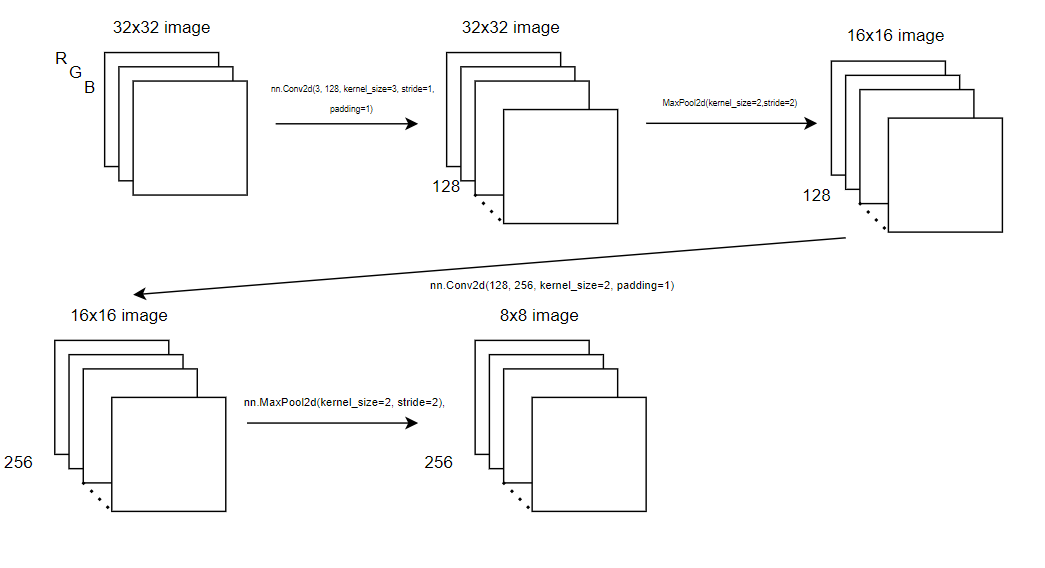
Специально было решено максимально упростить структуру, т.к. были попытки воспроизвести исходный AlexNet, но метрики были печальные...

In [307]:
from pytorch_lightning.callbacks import EarlyStopping

# Callback для EarlyStopping
early_stop_callback = EarlyStopping(
    monitor="val_loss",  # Метрика для отслеживания
    patience=3,          # Количество эпох без улучшения
    mode="min",          # Остановка, если метрика уменьшается
    verbose=True         # Вывод сообщений
)

# 4. Обучение модели

In [308]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
import os

data_module = CIFAR100_DataModule(batch_size=128, num_workers=2)

# Создаем Trainer
trainer = Trainer(
    max_epochs=15,                   # Максимальное количество эпох
    callbacks=[early_stop_callback], # Добавляем раннюю остановку, чтобы найти решение раньше
    logger = TensorBoardLogger(save_dir=os.getcwd(), version=1, name="lightning_logs"),
    accelerator="auto",              # Автоматически используем GPU
    devices="auto"                   # Автоматически выбирает устройство
)
# Обучение модели
model = AlexNet(num_classes=100)

trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | features   | Sequential       | 134 K  | train
1 | classifier | Sequential       | 1.5 M  | train
2 | criterion  | CrossEntropyLoss | 0      | train
--------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.516     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 3.677


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.313 >= min_delta = 0.0. New best score: 3.364


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.175 >= min_delta = 0.0. New best score: 3.189


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 3.098


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.105 >= min_delta = 0.0. New best score: 2.993


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 2.965


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 2.952


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 2.943


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2.943. Signaling Trainer to stop.


# 5. Проверка результатов

In [310]:
# Тестирование
trainer.test(model, data_module)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.382099986076355
        test_loss           3.0419843196868896
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 3.0419843196868896, 'test_acc': 0.382099986076355}]

<table>
  <tr>
    <td>
      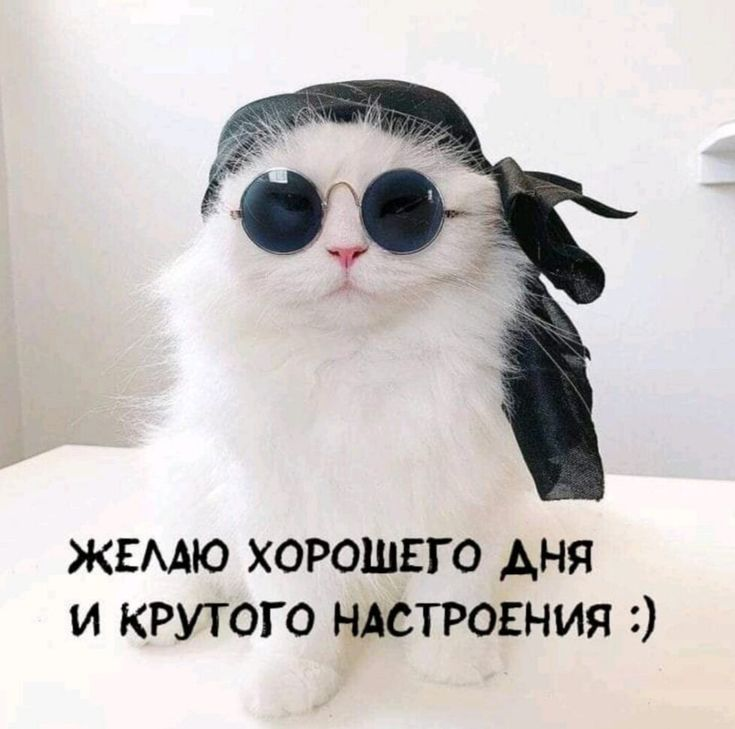
    </td>
  </tr>
</table>